In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import AdaBoostClassifier 

import pandas as pd
import json
import os
import re

import pickle
import nltk
from nltk.tokenize import word_tokenize

import gensim 
from gensim.models import Word2Vec
import gensim.downloader


import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /homes/lgf21/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
tqdm.pandas()

# Opening Files: 

In [4]:
rcatt_data = '../src/rcatt_training_data_original.csv'
scraped_data = '../src/training_dataset_full.csv'

In [5]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

ParserError: Error tokenizing data. C error: EOF inside string starting at row 13

In [6]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

# Merging Files: 

In [7]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tech_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [8]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('T') and col[1:].isdecimal()]]

In [9]:
s_r = list(set(Y_s.columns).difference(set(Y_r.columns)))

In [10]:
r_s = list(set(Y_r.columns).difference(set(Y_s.columns)))

In [11]:
rs = list(set(Y_s.columns).intersection(set(Y_r.columns)))

In [12]:
Y1 = Y_s[rs]
Y1[r_s] = 0
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the techniques in Y1

<ipython-input-12-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-12-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
<ipython-input-12-a4f835d7c67e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y

# Split dataset:

In [13]:
X_r_train, X_test_text, Y_r_train, Y_test = train_test_split(X_r, Y_r, test_size=0.3,
                                                    random_state = 10)

In [14]:
X_train_text = pd.concat([X_r_train, X_s])

In [15]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

# Feature Selection: 

In [53]:
def feature_extraction(featureExtract, X_train_text, X_test_text, average = False):
    if featureExtract in ['CountVectorizer', 'TfIdfVectorizer']:
        if featureExtract== 'CountVectorizer':
            fe = CountVectorizer(analyzer ='word', stop_words ='english', lowercase = True, min_df = 0.001, max_df = 0.99) # if words used less than 0.001 % --> ignore  
        else:
            fe = TfidfVectorizer(analyzer = 'word', stop_words='english', lowercase=True, min_df = 0.001, max_df=0.99)
        
        X_train = fe.fit_transform(X_train_text)
        X_train = pd.DataFrame(X_train.toarray(), columns = fe.get_feature_names()) 
        X_test = fe.transform(X_test_text)
        X_test = pd.DataFrame(X_test.toarray(), columns = fe.get_feature_names())
    
    else:
        model = gensim.downloader.load(featureExtract)
        # sent is tokenised sentence on which we do the embedding
        def get_embeddings(sent):
            # if text not in vocab:
            words_in_vocab = [word for word in sent if word in model]
            if not words_in_vocab:
                return np.zeros_like(model['the'])
            emb = model[words_in_vocab]
            return np.mean(emb, axis=0) if average else np.sum(emb, axis=0)
        #perform tokenisation
        X_train = pd.DataFrame(X_train_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
        X_test = pd.DataFrame(X_test_text.progress_apply(nltk.word_tokenize).progress_apply(get_embeddings).values.tolist())
    return X_train, X_test
        
        
        

In [74]:
#X_train, X_test = feature_extraction('CountVectorizer', X_train_text, X_test_text)

In [17]:
#X_train, X_test = feature_extraction('TfIdfVectorizer', X_train_text, X_test_text)

In [54]:
X_train, X_test = feature_extraction('glove-wiki-gigaword-100', X_train_text, X_test_text)

100%|██████████| 441/441 [00:08<00:00, 51.59it/s]


In [55]:
X_train.shape

(2147, 100)

In [ ]:
#X_train, X_test = feature_extraction('glove-wiki-gigaword-100', X_train_text, X_test_text)

# Measuring Cosine Similarity to Remove Duplicates: 

In [18]:
similarities = cosine_similarity(X_train, X_test)

In [19]:
# check if articles have a cosine similarity of more than 90%
duplicates = set() 
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            
            duplicates.add(i)

In [20]:
# remove similar articles
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]

# Visualisations:

<AxesSubplot:>

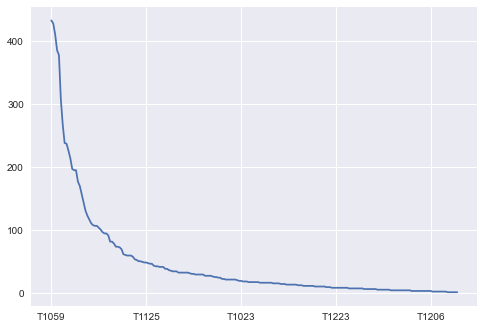

In [21]:
Y_train.sum(axis=0).sort_values(ascending=False).plot()

<AxesSubplot:>

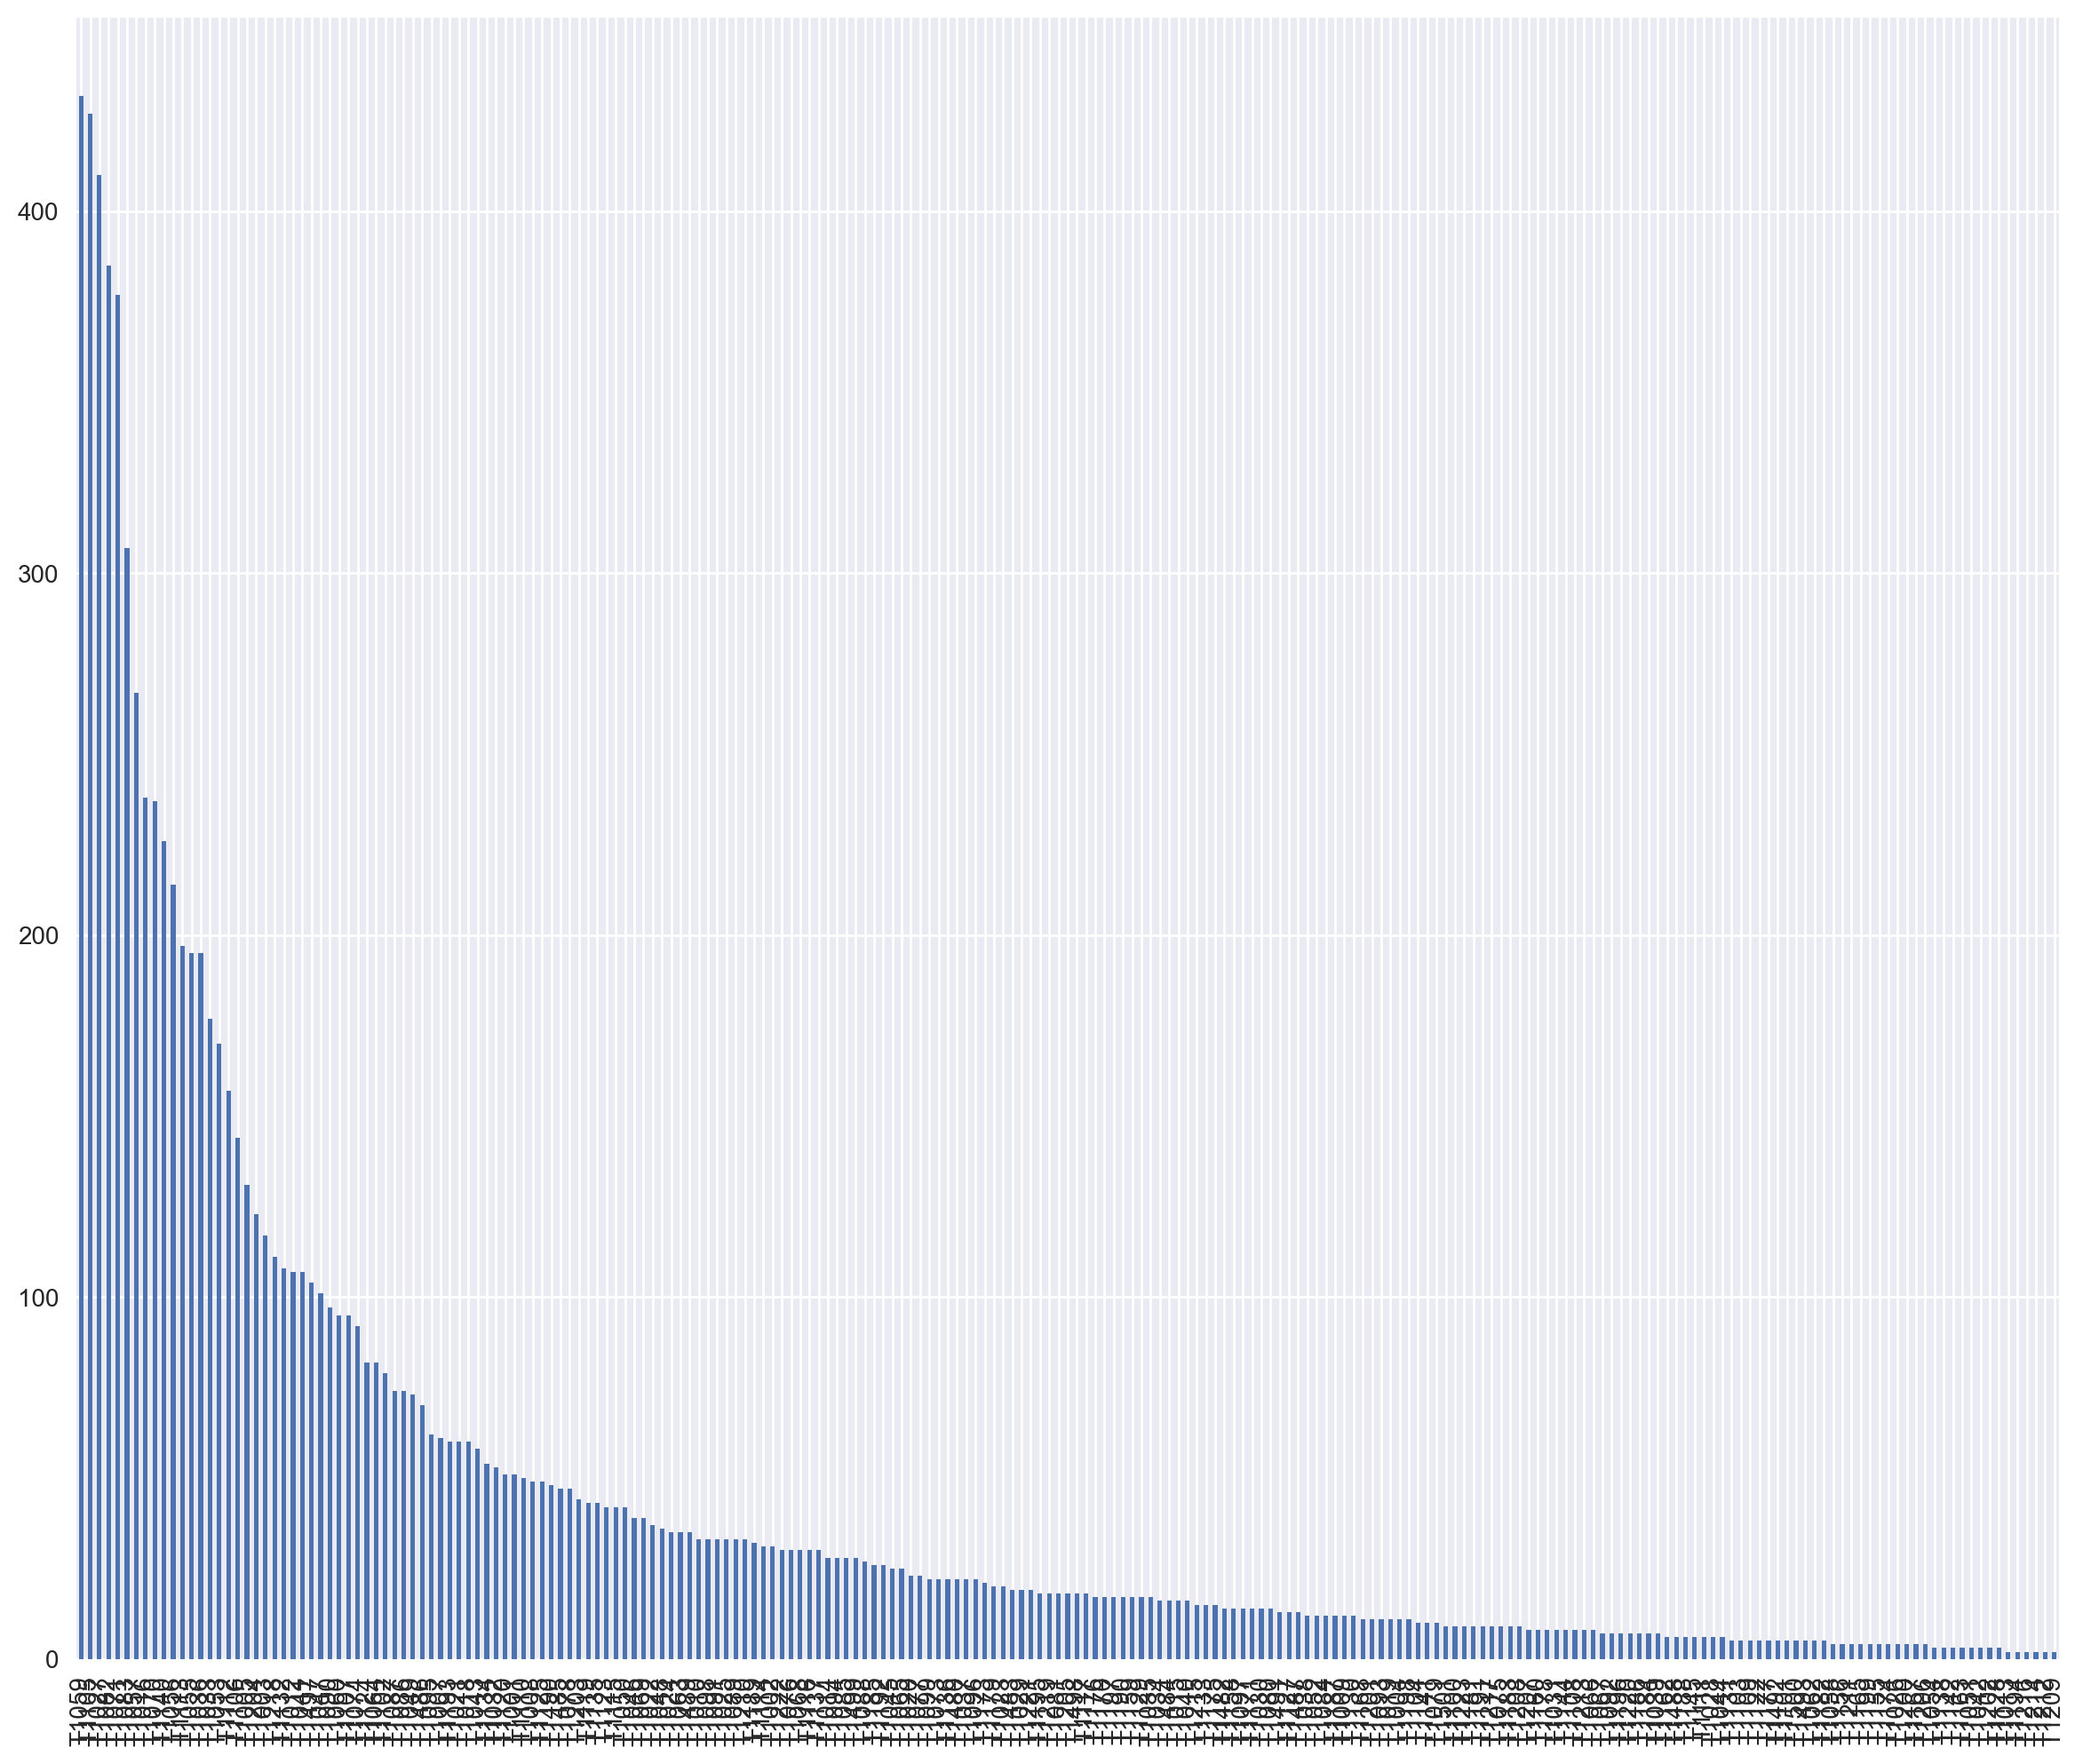

In [28]:
fig, ax = plt.subplots(figsize=(100, 12))
Y_train.sum(axis=0).sort_values(ascending=False).plot(kind='bar', ax = ax)

# Evaluation:

In [46]:
def evaluation(Y_pred, Y_test):
    macro_precision = precision_score(Y_test, Y_pred, average ='macro')
    micro_precision = precision_score(Y_test, Y_pred, average ='micro')
    macro_recall = recall_score(Y_test, Y_pred, average='macro')
    micro_recall = recall_score(Y_test, Y_pred, average='micro')
    macro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')
    micro_fscore = fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')
    l_metric = ['macro precision', 'micro precision', 'macro recall', 'micro recall', 'macro fscore', 'micro fscore']
    l_result = [macro_precision, micro_precision, macro_recall, micro_recall, macro_fscore, micro_fscore]
    df_res = pd.DataFrame({'metric': l_metric, 'result': l_result})
    return df_res

## Naive Bayes: 

In [25]:
# Open Pickle: 

#with open('bayes_technique.pickle', 'rb') as handle:
#    naive_bayes_classifier = pickle.load(handle)

In [40]:
naive_bayes_classifier = OneVsRestClassifier(MultinomialNB())
naive_bayes_classifier.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
y_pred_proba = pd.DataFrame(naive_bayes_classifier.predict_proba(X_test), columns = Y_test.columns)

In [ ]:
y_pred = (y_pred_proba > 0.005).astype(int) # if increase threshold, recall decreases and precision (could) increase

In [ ]:
evaluation(y_pred, Y_test)

In [35]:
# Save as pickle: 

with open('bayes_technique.pickle', 'wb') as handle:
    pickle.dump(naive_bayes_classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)

## SVC:

In [56]:
# Train and test: First delete techniques less than 9 
# We fix the random state to have the same dataset in our different tests

sv_classifier = OneVsRestClassifier(LinearSVC(penalty = 'l2', loss = 'squared_hinge', dual = False, max_iter = 1000, class_weight = 'balanced', random_state=42), n_jobs = 1)
sv_classifier.fit(X_train, Y_train)


ValueError: Found input variables with inconsistent numbers of samples: [2147, 2038]

In [48]:
Y_pred = pd.DataFrame(sv_classifier.predict(X_test), columns=Y_test.columns)

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

In [89]:
precision_score(Y_test, Y_pred, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2624644340759994

In [90]:
precision_score(Y_test, Y_pred, average ='micro')

0.35304150085275726

In [91]:
fbeta_score(Y_test, Y_pred, beta=0.5, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.24831898899038773

In [92]:
fbeta_score(Y_test, Y_pred, beta=0.5, average ='micro')

0.3538461538461538

In [93]:
recall_score(Y_test, Y_pred, average='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2579511443075406

In [94]:
recall_score(Y_test, Y_pred, average='micro')

0.3571017826336975

## Multi-label KNN: 

In [95]:
knn = MLkNN(k = 3)

In [96]:
# train
knn.fit(X_train.values, Y_train.values)

# predict
predictions = knn.predict(X_test.values)

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [97]:
fbeta_score(Y_test, predictions, beta=0.5, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.08042496930053798

In [98]:
fbeta_score(Y_test, predictions, beta=0.5, average ='micro')

0.20097113568923652

In [99]:
precision_score(Y_test, predictions, average ='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.10968892524236602

In [100]:
precision_score(Y_test, predictions, average ='micro')

0.30284552845528456

In [101]:
recall_score(Y_test, predictions, average='macro')

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.05011563320094632

In [102]:
recall_score(Y_test, predictions, average='micro')

0.08568142610695802

## Logistic Regression:

In [34]:
# reduce dimension using pca: 

pca = PCA(n_components=150)
pca.fit(X_train)
pca_result = pca.transform(X_train)
x_test_result = pca.transform(X_test )

In [35]:
log_reg = OneVsRestClassifier(LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs', max_iter = 1000)).fit(X_train, Y_train)

predictions = log_reg.predict(X_test)


In [36]:
evaluation(predictions, Y_test)

/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liviafries/opt/anaconda3/envs/auto_cti/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,metric,result
0,macro precision,0.076855
1,micro precision,0.934783
2,macro recall,0.010326
3,micro recall,0.024727
4,macro fscore,0.028700
5,micro fscore,0.111804


## DT AdaBoost

In [57]:
dt_adaboost = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(X_train, Y_train)
predictions_ada = dt_adaboost.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [2147, 2038]

In [ ]:
evaluation(predictions_ada, Y_test)

# Classifier Chain:

In [ ]:
def chain_model(model):
    model_chain = ClassifierChain(model, order='random', random_state=0)
    return model_chain

In [ ]:
chain = chain_model(log_reg) # change model appropriately